# Проект: Принятие решений в бизнесе.


**Описание проекта**: Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки. 

**Цель исследования**: Приоритизировать гипотезы, изучить кумулятивную выручку, кумулятивный средний чек, конверсию пользователей и их изменения. На основе этих данных запустить A/B-тест и проанализировать результаты. 

**Ход исследования**:
- Приоритизация гипотез методами ICE и RICE
- Построение графиков кумулятивной выручки, кумулятивного среднего чека, графиков их изменений, их анализ
- Построение графиков конверсии, их анализ
- Поиск аномальных пользователей и выбросов
- Подсчет статистической значимости различий в среднем чеке и конверсии между пользователями по "сырым" данным
- Подсчет статистической значимости различий в среднем чеке и конверсии между пользователями по "очищенным" данным
- Решение по итогам теста.

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 15)})
import datetime as dt
import scipy.stats as stats
import warnings
warnings.simplefilter('ignore')

In [2]:
# Загружаем датасеты
pd.set_option('display.max_columns', None)
df = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])
visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])

In [3]:
# Выведем общую информацию о датафреймах visitors и orders, проверяем тип данных
display(orders.info())
display(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

In [4]:
# Проверим наличие явных дубликатов в датасетах orders и visitors
display(orders.duplicated().sum())
display(visitors.duplicated().sum())

0

0

In [5]:
# Скорректируем наименование столбцов
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id',})

In [6]:
# Выведем первые 5 строк датасетов orders и visitors
display(orders.head())
display(visitors.head())

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


## Приоритизация гипотез.

### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [7]:
# Рассмотрим таблицу гипотез с параматерами Reach, Impact, Confidence, Effort.
pd.options.display.max_colwidth = 120
display(df)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [8]:
# Применим фреймворк ICE как отношение произведения параметров Impact и Confidence к Efforts
df['ICE'] = df['Impact'] * df['Confidence']/ df['Efforts']
# Сортируем по убыванию приоритета
df.sort_values(by = 'ICE', ascending=False).round(2)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


При применении фреймворка ICE наиболее приоритетной будет гипотеза 8: "Запустить акцию, дающую скидку на товар в день рождения	".

### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [28]:
# # Применим фреймворк RICE как отношение произведения параметров Reach, Impact и Confidence к Efforts
df['RICE'] = df['Reach']* df['Impact'] * df['Confidence']/ df['Efforts']
# Сортируем по убыванию приоритета
df.sort_values(by = 'RICE', ascending=False).round(2)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


При применении фреймворка RICE наиболее приоритетной будет гипотеза 7: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

Приоритет поменялся, т.к. метод RICE в отличие от ICE учитывает параметр Reach - охват пользователей. С учетом охвата пользователей гипотеза номер 8, которая была наиболее приоритетная при применении фреймворка ICE сместилась на пятое место. Это логично, потому что запуск акции для пользователей в день их рождения будет иметь сравнительно небольшой охват.

## Анализ A/B-теста.

In [10]:
# создаем массив уникальных пар значений дат и групп теста
grouped_dates = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
aggregated_orders = grouped_dates.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
                                 .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
aggregated_visitors = grouped_dates.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                   .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = aggregated_orders.merge(aggregated_visitors, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data.head()) 
display(cumulative_data.tail())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


,date,group,orders,buyers,revenue,visitors
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736
61,2019-08-31,B,640,586,5907760,18916


### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

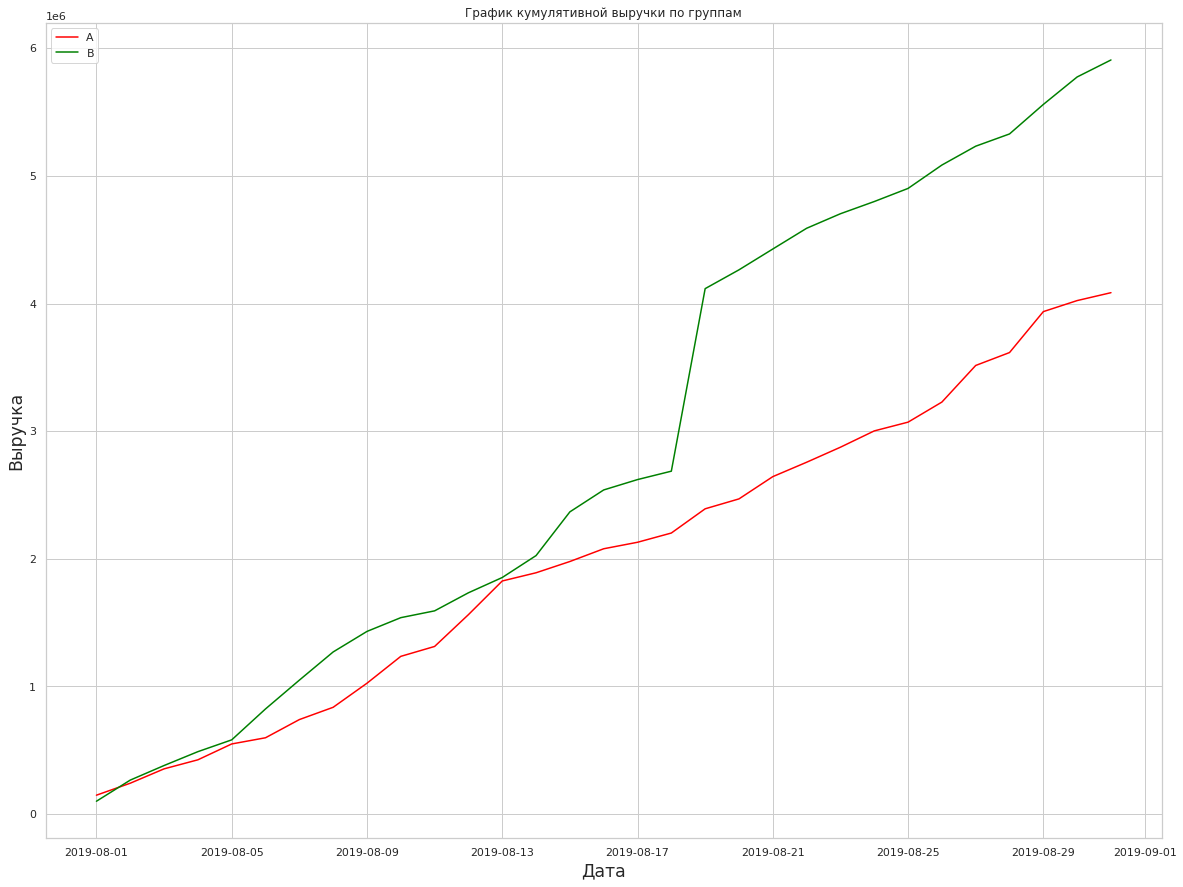

In [11]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
sns.set_theme(style="whitegrid", palette="pastel")
sns.lineplot(data = cumulative_revenue_a, x = 'date', y = 'revenue', label='A', color='Red')
# Строим график выручки группы B
sns.lineplot(data = cumulative_revenue_b, x = "date", y = "revenue", label='B', color='Green')
plt.ylabel('Выручка', size='x-large')
plt.xlabel('Дата', size='x-large')
plt.title('График кумулятивной выручки по группам')
plt.legend()
plt.show()

Вывод: выручка обеих групп растет на протяжении рассматриваемого периода. Исходя из полученного графика можно заметить резкий рост выручки группы B 18-08-2019 , вероятно, связанный с каким-то выбросом (например, с дорогим интернет-заказом или большим их количеством). Рост выручки группы А не демонстрирует резких скачков.

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

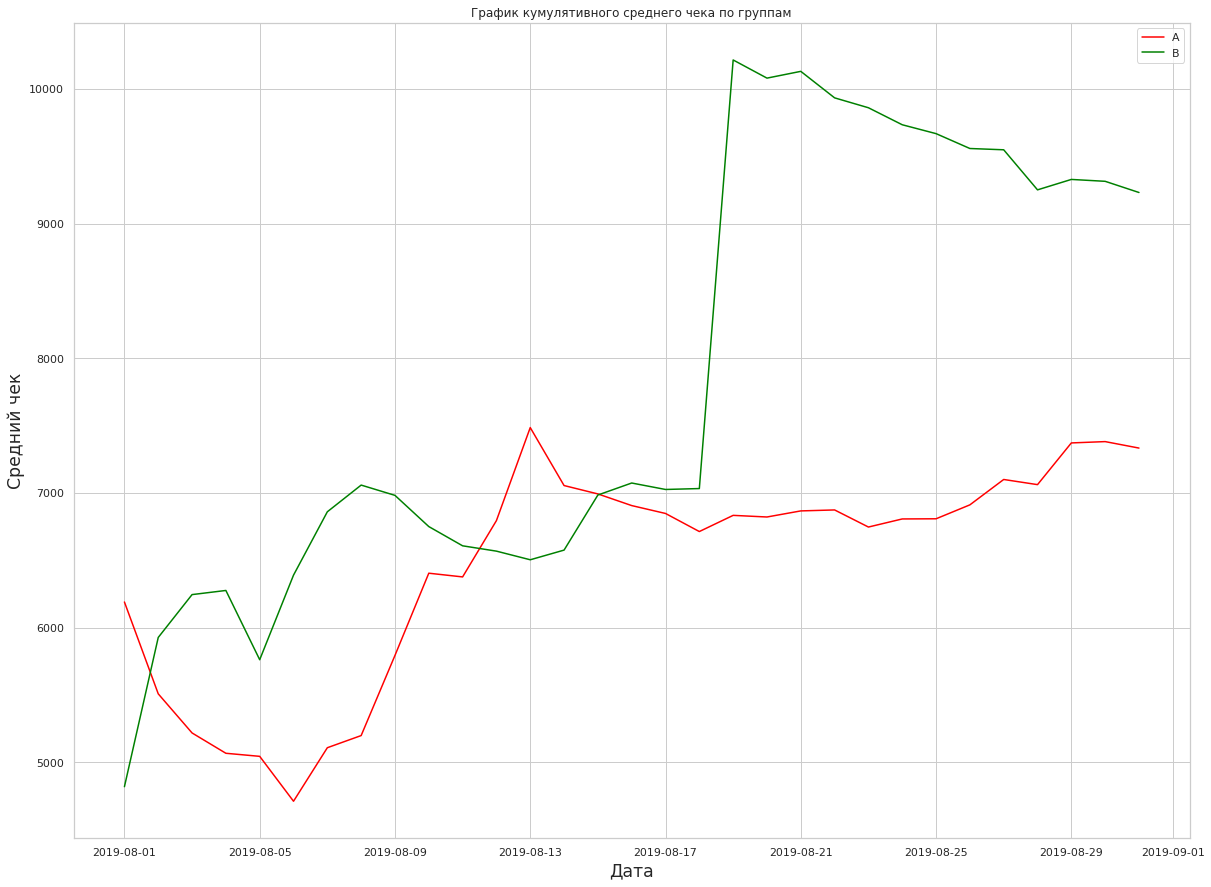

In [12]:
# Строим график среднего чека группы А
sns.set_theme(style="whitegrid", palette="pastel")
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A', color='Red')
# Строим график среднего чека группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B', color='Green')
plt.ylabel('Средний чек', size='x-large')
plt.xlabel('Дата', size='x-large')
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
plt.show()

Вывод: рост среднего чека группы А наблюдался с 06-08-2019 по 13-08-2019, после показатель стабилизировался в районе 7000 у.е., дальнейшего роста не наблюдалось, как и падения. Рост среднего чека группы B также происходил в указанный ранее период, при этом 18-08-2019 явно произошел выброс, после чего показатель кумулятивного среднего чека начал снижение.

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

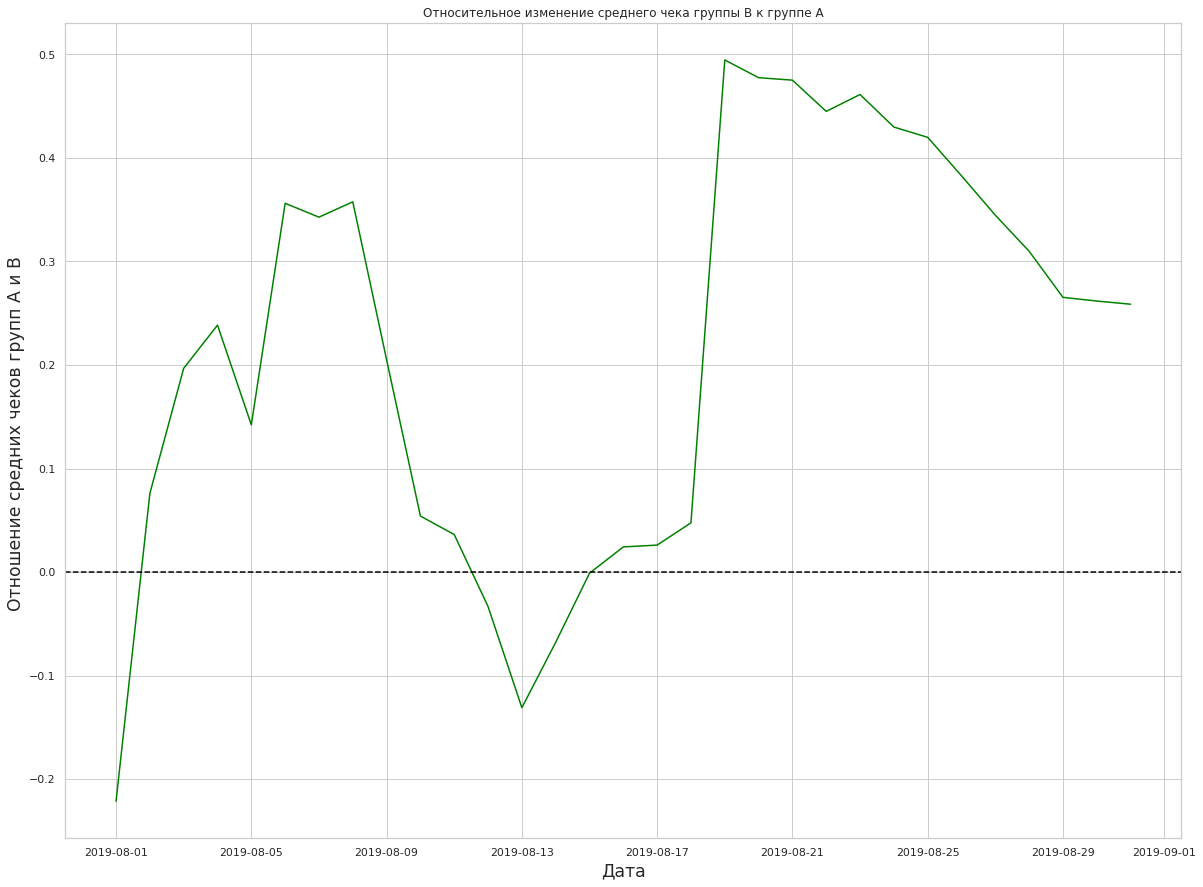

In [13]:
# собираем данные в одном датафрейме
сum_revenue_merged = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])
# считаем отношение средних чеков групп А и B 
сum_revenue_merged['revenue_ratio'] = ((сum_revenue_merged['revenue_B']/сum_revenue_merged['orders_B'])/(сum_revenue_merged['revenue_A']/сum_revenue_merged['orders_A'])-1)
# cтроим график отношения средних чеков
sns.set_theme(style="whitegrid", palette="pastel")
sns.lineplot(data = сum_revenue_merged, x = 'date', y = 'revenue_ratio', color='Green')
plt.title('Относительное изменение среднего чека группы B к группе A')
plt.ylabel('Отношение средних чеков групп А и B ', size='x-large')
plt.xlabel('Дата', size='x-large')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

Вывод: график относительного изменения среднего чека группы B к группе A повторяет динамику графиков среднего чека по группам: группа B росла быстрее группы А до 08-08-2019, потом произошло снижение и стабилизация на одном уровне с группой А, затем выброс существенно изменил соотношение в пользу группы B.

### Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

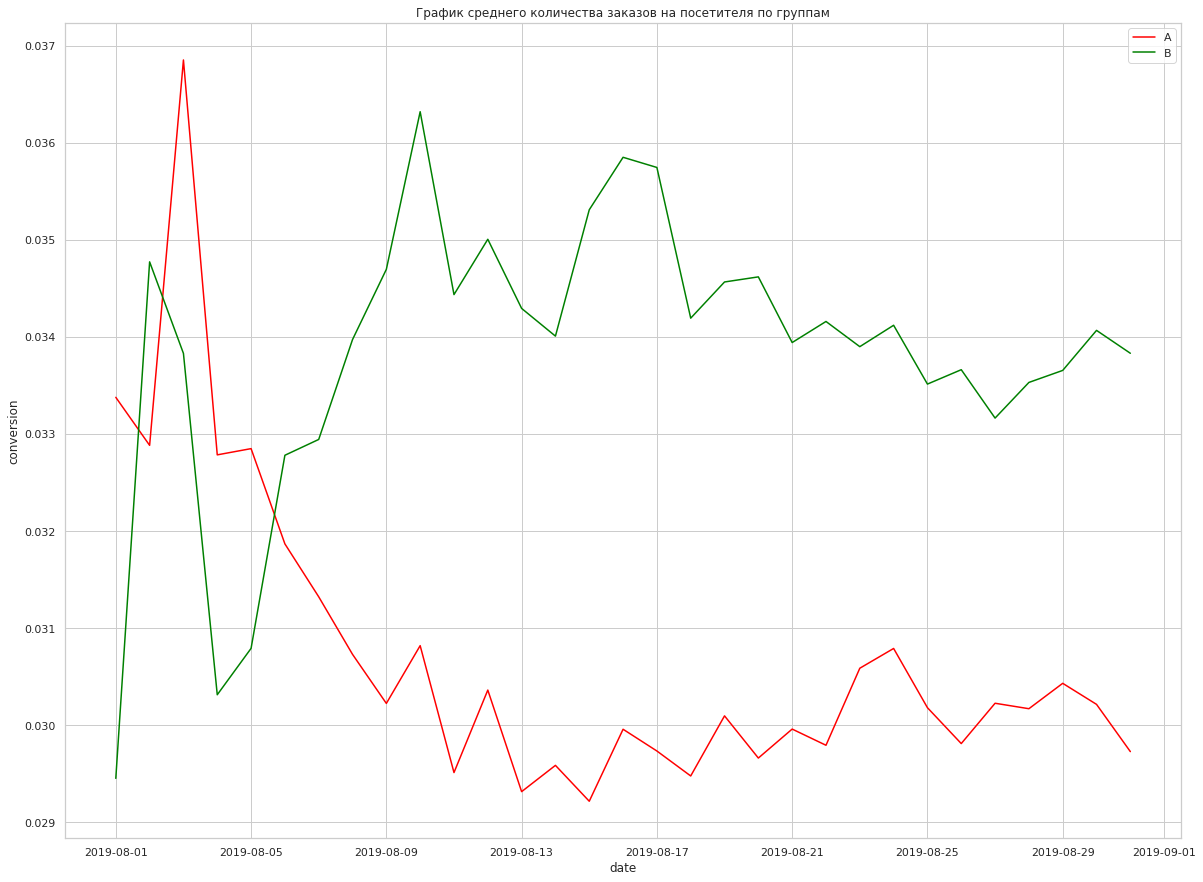

In [14]:
# считаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
sns.set_theme(style="whitegrid", palette="pastel")
sns.lineplot(data = cumulative_data_a, x = 'date', y = 'conversion', label='A', color='Red')
sns.lineplot(data = cumulative_data_b, x = 'date', y = 'conversion', label='B', color='Green')
plt.title('График среднего количества заказов на посетителя по группам')
plt.legend()
plt.show()

Вывод: среднее количество заказов на одного посетителя групп A и B с начала периода сильно разнились, конверсия группы B была гораздо ниже конверсии группы А на старте, но с 06-08-2019 группа B начала опережать группу A по этому показателю, одновременно с этим количество покупок на одного пользователя в группе А за этот период снизилось.

### Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.

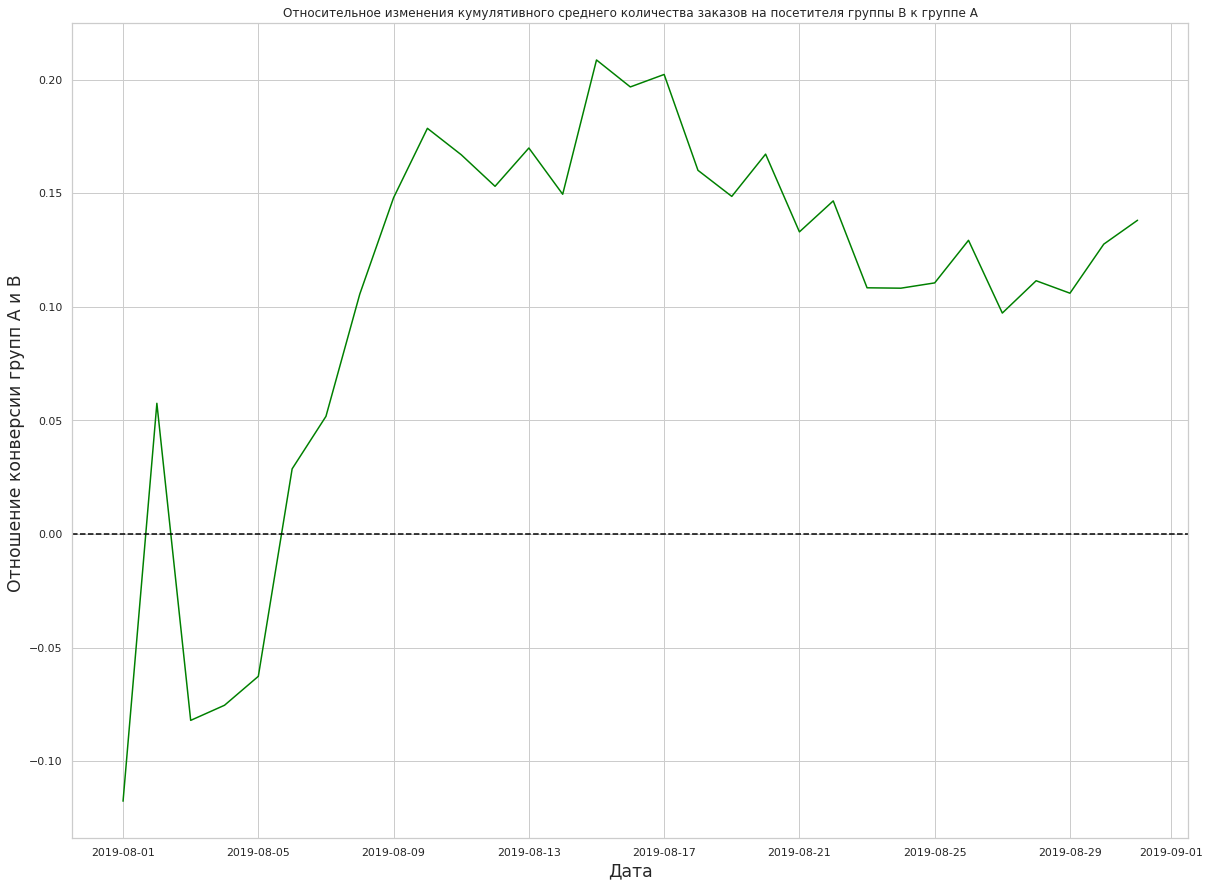

In [15]:
# собираем данные в одном датафрейме
cum_conversion_merged = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])
# считаем изменение кумулятивного среднего количества заказов на посетителя группы B к группе A
cum_conversion_merged['conversion_ratio'] = cum_conversion_merged['conversion_B']/cum_conversion_merged['conversion_A']-1
# cтроим график отношения конверсии группы B к группе А
sns.set_theme(style="whitegrid", palette="pastel")
sns.lineplot(data = cum_conversion_merged, x = 'date', y = 'conversion_ratio', color='Green')
plt.title('Относительное изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.ylabel('Отношение конверсии групп А и B ', size='x-large')
plt.xlabel('Дата', size='x-large')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Вывод: конверсия группы B была стабильно выше конверсии группы А на протяжении всего периода начиная с 06-08-2019. При этом рост отношения показателя конверсии группы B вызван во многом снижением показателя конверсии группы A за данный период.

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [16]:
#Подсчитаем количество заказов по пользователям 
user_orders = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
user_orders.columns = ['visitor_id', 'orders']
display(user_orders)

,visitor_id,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


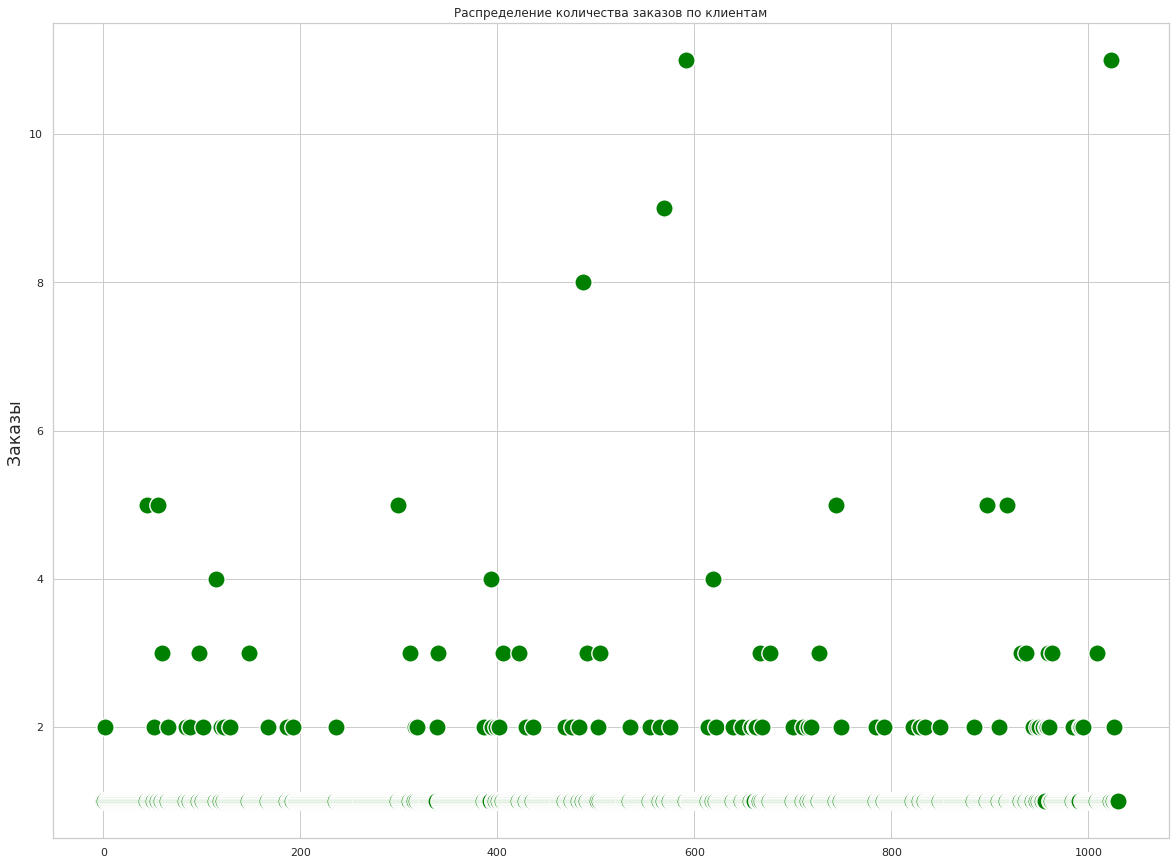

In [17]:
# Построим точечный график количества заказов по пользователям
x_values = pd.Series(range(0,len(user_orders)))
sns.set_theme(style="whitegrid", palette="pastel")
sns.scatterplot(x = x_values, y = user_orders['orders'], s=300, color='Green') 
plt.title('Распределение количества заказов по клиентам')
plt.ylabel('Заказы ', size='x-large')
plt.show()

Вывод: из графика видно, что большинство пользователей сделали 1-2 заказа за данный период. Однако есть и некоторое количество пользователей сделавших 3 заказа и более. Скорее всего, это аномалии.

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [18]:
np.percentile(user_orders['orders'], [95, 99])

array([2., 4.])

Вывод: 5% пользователей совершили 2 заказа и более, а 1% пользователей совершили 4 заказа и более. Последних можно считать за аномалии.

### Постройте точечный график стоимости заказов. Сделайте выводы и предположения.

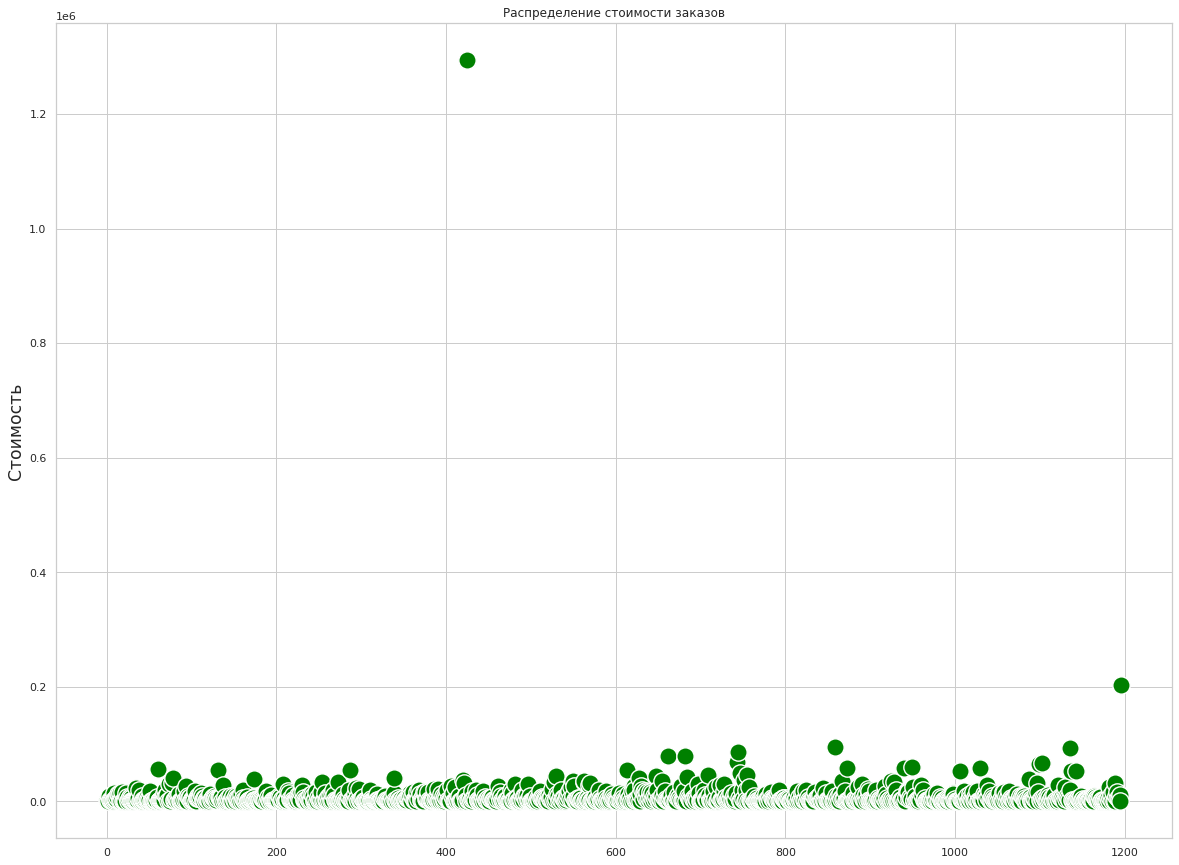

In [19]:
# Построим точечный график стоимости заказов по пользователям
x_values = pd.Series(range(0,len(orders['revenue'])))
sns.set_theme(style="whitegrid", palette="pastel")
plt.title('Распределение стоимости заказов')
plt.ylabel('Стоимость', size='x-large')
sns.scatterplot(x = x_values, y = orders['revenue'], s=300, color='Green') 
plt.show()

In [20]:
# Выведем описательную статистику по заказам
orders['revenue'].describe().round(2)

count       1197.00
mean        8348.01
std        39191.13
min           50.00
25%         1220.00
50%         2978.00
75%         8290.00
max      1294500.00
Name: revenue, dtype: float64

Вывод: из точечного графика и описательной статистики видно, чо 75% заказов имеют стоимость 8290 у.е. и меньше. При этом максимальная стоимость заказа составляет 1294500.00 у.е., что вместе с другими выбросами сильно влияет на среднее - 39191.13 у.е. При этом медианная стоимость одного заказа составляет 8348.01 у.е.

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [21]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Вывод: 5% заказов имеют стоимость в 28000 у.е. и больше, а 1% заказов имеют стоимость больше 58233.2 у.е. Учитывая описательную статистику приведенную ранее, можно считать эти данные за аномалии.

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.

В ранее проведенном анализе мы выяснили, что в данных есть аномалии и установили границу их определения. Посчитаем различия в среднем количестве заказов по сырым данным.

In [22]:
# Подготовка данных
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Выше представлены следующие данные:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

Сформулируем гипотезы. 
- H0: различий в среднем количестве заказов между группами нет. 
- H1: различия в среднем количестве заказов между группами есть.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Гипотезы сформулированы верно!
</div>

In [23]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']
# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
# Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой
print('p-значение:',"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1.  Округлим до трёх знаков после запятой
print('относительный прирост группы B:',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-значение: 0.017
относительный прирост группы B: 0.138


Вывод: P-value составляет 0.017, что меньше 5% значения. Это говорит нам о том, что по "сырым" данным нулевая гипотеза об отсутствии различий отвергается, между группами имеются статистически значимые различия. Прирост группы B по "сырым" данным составляет 13,8% относительно группы А.

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

In [24]:
# уберём 5% пользователей с наибольшим числом заказов (больше или равно 3) и от 1% до 5% пользователей с дорогими заказами (дороже 28000)
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >= 3]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] >= 3]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] >= 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64
74


Итого из обеих групп мы исключаем 74 аномальных клиента.

In [25]:
# подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
# Применим статистический критерий Манна-Уитни к полученным выборкам:
print('p-значение:','{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('относительный прирост группы B:','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-значение: 0.013
относительный прирост группы B: 0.173


Вывод: P-value составляет 0.013, что ниже статистического уровня значимости в 5%, нулевая гипотеза отвергается. Между группами A и B имеются различия в среднем количестве заказов на посетителя. В группе B количество заказов на одного клиента больше на 17,3%.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Сформилируем гипотезы:
- H0: Различий в среднем чеке заказа между группами нет.
- H1: Различия в среднем чеке заказа между группами есть.

In [26]:
# создадим переменные с вырочкой по группам
revenue_sample_a = orders[orders['group']=='A']
revenue_sample_b = orders[orders['group']=='B']

# Применим статистический критерий Манна-Уитни к выборкам revenueCummulativeA и revenueCummulativeB:
print('p-значение:','{0:.3f}'.format(stats.mannwhitneyu(revenue_sample_a['revenue'], revenue_sample_b['revenue'])[1]))
print('относительный прирост группы B:','{0:.3f}'.format(revenue_sample_b['revenue'].mean()/revenue_sample_a['revenue'].mean()-1)) 

p-значение: 0.729
относительный прирост группы B: 0.259


Вывод: P-value равен 0.729, что выше статистического уровня значимости в 5%, альтернативная гипотеза отвергается. При этом средний чек группы B на 25,9% выше группы А. Это говорит об искажении значения среднего чека из-за выбросов.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [27]:
# подготовим выборки количества заказов по пользователям по группам теста
filtered_revenue_sample_a = revenue_sample_a[np.logical_not(orders['visitor_id'].isin(abnormalUsers))]
filtered_revenue_sample_b = revenue_sample_b[np.logical_not(orders['visitor_id'].isin(abnormalUsers))]
# Применим статистический критерий Манна-Уитни к полученным выборкам:
print('p-значение:','{0:.3f}'.format(stats.mannwhitneyu(filtered_revenue_sample_a['revenue'], filtered_revenue_sample_b['revenue'])[1]))
print('относительный прирост группы B:','{0:.3f}'.format(filtered_revenue_sample_b['revenue'].mean()/filtered_revenue_sample_a['revenue'].mean()-1)) 

p-значение: 0.738
относительный прирост группы B: -0.020


Вывод: P-value составляет 0.738, что выше статистического уровня значимости в 5%, альтернативная гипотеза отвергается, между группам A и B нет разницы в среднем чеке. При этом в группе B "очищенный" средний чек на 2% ниже группы А.

### Итог A/B теста.

По итогам проведения анализа можно сделать следующие выводы:
- Среднее количество заказов на одного пользователя в группе B больше, чем в группе A, что подтвержадется при подсчете статистической значимости различий между двумя группами.
- После фильтрации данных группы B не было обнаружено стаатистически значимых различий по показателю среднего чека между группами.

Исходя из вышесказанного проведение теста можно остановить. Принимая во внимание тот факт, что статистически значимых различий в показателе среднего чека после фильтрации данных между группами A и B нет, нельзя сделать вывод об одназначной победе одной из групп, т.к. несмотря на лучший показатель среднего количества заказов на одного пользователя, группа B не смогла продемонстрировать рост среднего чека, т.е. прибыли. Большее значение среднего чека группы B было вызвано наличием в группе нескольких крупных заказов, которые искажали анализ в пользу этой группы. 